In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
#filling missing values
train["Age"] = train["Age"].fillna(30)
train["Embarked"].fillna("S", inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
#transform non-numerical labels to numerical labels
encoder = LabelEncoder()
for col in ('Sex','Embarked'):
    train['Sex'] = encoder.fit_transform(train['Sex'])
    train['Embarked'] = encoder.fit_transform(train['Embarked'])

In [4]:
#Features
train_x = train.drop(["PassengerId","Name","Ticket","Cabin","Survived"], axis=1)
#label
train_y = train["Survived"]
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [5]:
#Choose only the data that contains survivors
survived_label = train.groupby(['Survived'])
alive = survived_label.get_group(1)

In [6]:
#Choose only the data that contains dead people
dead = survived_label.get_group(0)

In [7]:
#ALIVE
#FEATURES
alive_x = alive.drop(["PassengerId","Name","Ticket","Cabin","Survived"], axis=1)
#label
alive_y = alive["Survived"]
alive_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
8,3,0,27.0,0,2,11.1333,2
9,2,0,14.0,1,0,30.0708,0


In [8]:
#DEAD
#FEATURES
dead_x = dead.drop(["PassengerId","Name","Ticket","Cabin","Survived"], axis=1)
#label
dead_y = dead["Survived"]
dead_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
4,3,1,35.0,0,0,8.0500,2
5,3,1,30.0,0,0,8.4583,1
6,1,1,54.0,0,0,51.8625,2
7,3,1,2.0,3,1,21.0750,2


In [9]:
#Sampling the data 80% train 20% test
#GENERAL
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#ALIVE
train_alive_x, test_alive_x, train_alive_y, test_alive_y = train_test_split(alive_x, alive_y, 
                                                  test_size=0.2, 
                                                  random_state=1)
#DEAD
train_dead_x, test_dead_x, train_dead_y, test_dead_y = train_test_split(dead_x, dead_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

In [10]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:hinge', max_depth = 6, learning_rate=0.3)
#fit = training
model.fit(train_x, train_y)
#predictions
predict_alive = model.predict(test_alive_x)
print(np.round(accuracy_score(test_alive_y,predict_alive)*100, 2),'%')
print('\nPredictions', predict_alive)

94.2 %

Predictions [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [11]:
predict_prob = model.predict_proba(test_alive_x)

In [12]:
#converting prob values to list
df_prob = pd.DataFrame(predict_prob)
s_prob_alive = df_prob[df_prob.columns[1]] 
list_prob_alive = s_prob_alive.values.tolist()

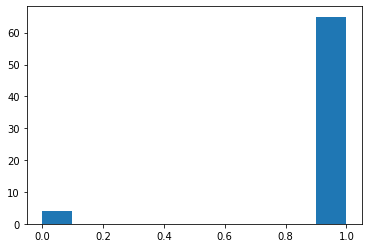

In [13]:
hist_alive = plt.hist(list_prob_alive, range=(0,1))

In [14]:
#converting prob values to list
predict_dead = model.predict(test_dead_x)
predict_prob_dead = model.predict_proba(test_dead_x)
df_prob_dead = pd.DataFrame(predict_prob_dead)
s_prob_dead = df_prob_dead[df_prob_dead.columns[1]] 
list_prob_dead = s_prob_dead.values.tolist()

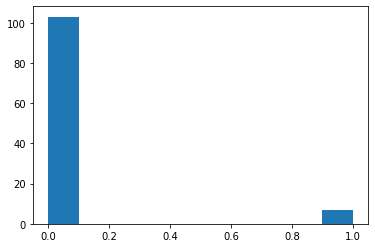

In [15]:
hist_dead = plt.hist(list_prob_dead, range=(0,1))

Text(0.5, 1.0, 'Results using XGB')

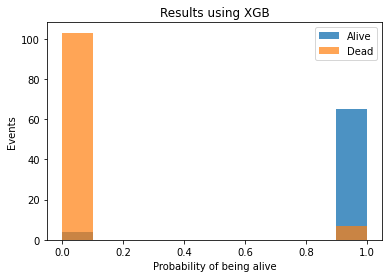

In [16]:
plt.hist(list_prob_alive, range=(0,1), alpha=0.8,label='Alive')
plt.hist(list_prob_dead, range=(0,1), alpha=0.7, label='Dead')
plt.legend(loc='upper right')
plt.xlabel('Probability of being alive')
plt.ylabel('Events')
plt.title('Results using XGB')

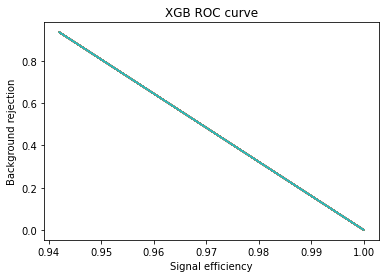

In [17]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

list_prob_alive = sorted(list_prob_alive)
list_prob_dead = sorted(list_prob_dead)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
eficiency = []
background_rejection = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    vivos_aceptados = len(list_prob_alive)
    muertos_rechazados = 0


    for i, v in enumerate(list_prob_alive):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            vivos_aceptados-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(list_prob_alive)-1:
            vivos_aceptados=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(list_prob_dead):
        if cut<=m:
            muertos_rechazados+=i
            break
        if i==len(list_prob_dead)-1:
            muertos_rechazados=len(list_prob_dead)
    
    #ALMACENA EN LA LISTA
    eficiency.append(vivos_aceptados/len(list_prob_alive))
    background_rejection.append(muertos_rechazados/len(list_prob_dead))

    neural = plt.plot(eficiency, background_rejection)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('XGB ROC curve')